In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Get the stock quote 
# df = web.DataReader('INFY.NS', data_source='yahoo', start='2012-01-01', end='2021-06-29') 
df = pd.read_csv("Dataset/INFY.csv")
# droping null values
df = df.dropna()
#Show the data 
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-06-18,316.500000,318.049988,311.944000,313.862000,172.476105,710072.0
1,2012-06-19,312.500000,313.212006,307.037994,309.819000,170.254333,679992.0
2,2012-06-20,310.000000,310.600006,306.862000,308.830994,169.711426,563008.0
3,2012-06-21,306.875000,312.681000,305.287994,311.524994,171.191849,457992.0
4,2012-06-22,306.125000,310.531006,305.375000,309.388000,170.017517,1230912.0
...,...,...,...,...,...,...,...
2089,2020-12-07,1144.000000,1151.400024,1136.150024,1144.050049,1144.050049,521440.0
2090,2020-12-08,1144.400024,1166.750000,1144.400024,1153.849976,1153.849976,793534.0
2091,2020-12-09,1167.150024,1179.000000,1157.300049,1175.150024,1175.150024,490595.0
2092,2020-12-10,1163.699951,1171.449951,1151.449951,1167.500000,1167.500000,380940.0


In [3]:
df.shape

(2088, 7)

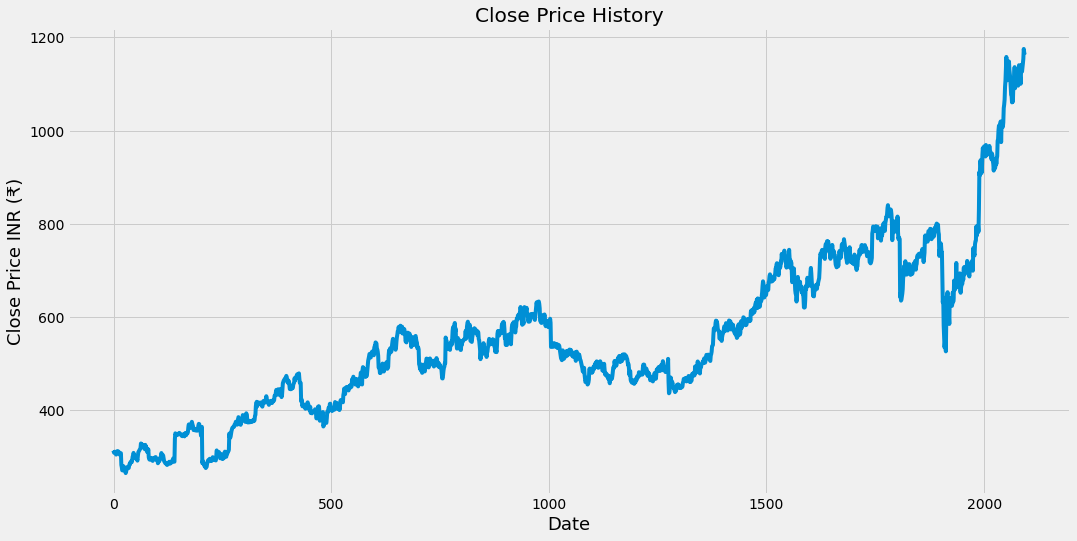

In [4]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price INR (₹)',fontsize=18)
plt.show()

In [5]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [6]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [7]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [8]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [10]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [11]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
1611/1611 [==============================] - 36s 14ms/step - loss: 0.0025
Epoch 2/5
1611/1611 [==============================] - 22s 14ms/step - loss: 3.5357e-04
Epoch 3/5
1611/1611 [==============================] - 23s 14ms/step - loss: 2.8380e-04
Epoch 4/5
1611/1611 [==============================] - 23s 14ms/step - loss: 2.6112e-04
Epoch 5/5
1611/1611 [==============================] - 23s 14ms/step - loss: 1.7455e-04


In [13]:
#Save the model
model.save("Infosys_Prediction_model", save_format='h5')

In [14]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [15]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [16]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [17]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [18]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

22.250172692965293

<ipython-input-19-e18d7d18561d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


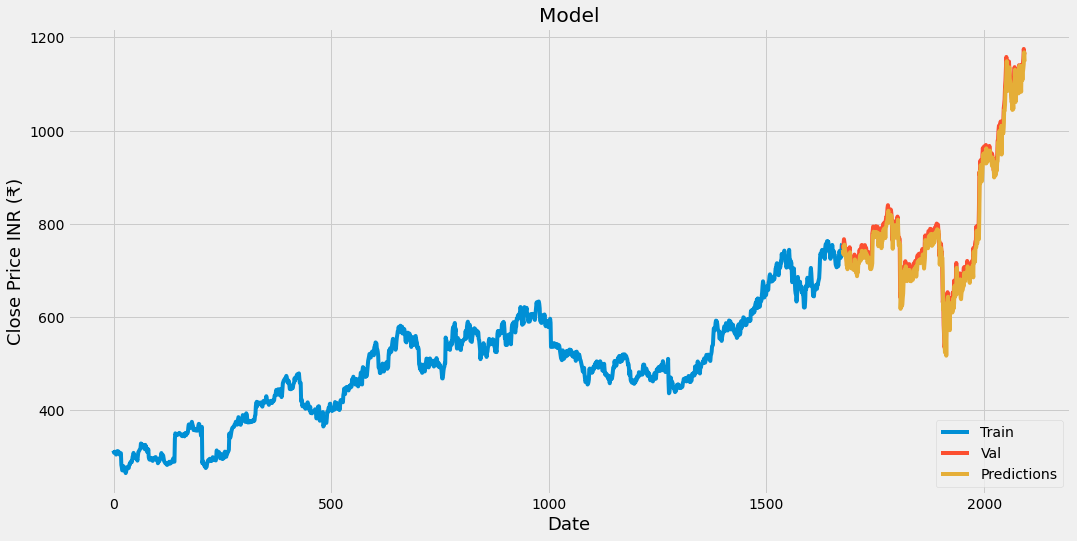

In [19]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR (₹)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.savefig('Infosys_Predicted_Graph.png')
plt.show()

In [20]:
#Show the valid and predicted prices
valid

,Close,Predictions
1675,754.049988,744.300842
1676,748.250000,740.707703
1677,756.250000,734.475037
1678,767.150024,744.217957
1679,759.849976,755.425720
...,...,...
2089,1144.050049,1125.567261
2090,1153.849976,1133.036255
2091,1175.150024,1143.008179
2092,1167.500000,1167.879028
